In [86]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.MarkovModel import compute_context_aware_transition_matrix
from libs.MarkovModel import compute_transition_matrix
from libs.MarkovModel import compute_log_likelihood_and_perplexity
from libs import encode_float_filename, decode_float_filename
from libs.MarkovModel import generate_balanced_thresholds
from libs.MarkovModel import assign_groups

In [87]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / np.sum(e_x)

def compute_context_aware_transition_matrix_aggregated(trafficSource, classDistribu_predicted, lenWindow, mapping, alpha=1e-20):
    y_labels = range(0, lenWindow+1)
    P = np.zeros((len(y_labels), len(y_labels)))
    traffic_count = np.zeros((len(y_labels), 1))

    for i in range(trafficSource.shape[0] - 1):
        y_source = mapping[int(trafficSource[i])]
        for sigma_next in range(lenWindow+1):
            y_next = mapping[sigma_next]
            prob = softmax(classDistribu_predicted[i, :])
            P[y_source, y_next] += prob[sigma_next]
            traffic_count[y_source] += 1

    for i in range(len(y_labels)):
        P[i, :] /= (traffic_count[i] + 1)

    P = P + alpha
    P = P / P.sum(axis=1, keepdims=True)

    return P, traffic_count

In [ ]:
dbParams_list = [0.01, 0.15]
direction_list = ["forward", "backward"]
mode_list = ["fixed", "adaptive"]
lenWindow_list = [10, 20, 30]
N_group_list = [5,15,20]
verbose = False

dbParams = dbParams_list[0]
direction = direction_list[0]
lenWindow = lenWindow_list[0]
mode = mode_list[0]

perpCF_results = {}
perpCA_results = {}
for dbParams, direction in zip(dbParams_list, direction_list):
    for mode in mode_list:
        perpCF_row = []
        perpCA_row = []
        for lenWindow, N_group in zip(lenWindow_list, N_group_list):
            dbpString = encode_float_filename(dbParams)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsTrain = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsTest = pickle.load(file)
            # ===== Compute transition matrix =====
            N_aggregation = N_group
            theresholds = generate_balanced_thresholds(resultsTrain['trafficTarget_actual'].astype(int), N_aggregation)
            mapping = assign_groups(np.array(range(0, lenWindow+1)), theresholds)
            #print(mapping)
            #print(np.unique(mapping).shape[0], N_aggregation)
            transMatrixContextAwareAggregated, traffic_count = compute_context_aware_transition_matrix_aggregated(
                resultsTrain['trafficSource_actual'].astype(int), 
                resultsTrain['classDistribu_predicted'], 
                lenWindow, 
                mapping)
            transMatrixContextFree = compute_transition_matrix(
                assign_groups(resultsTrain['trafficSource_actual'].astype(int), theresholds), 
                assign_groups(resultsTrain['trafficTarget_actual'].astype(int), theresholds), 
                lenWindow, 
                alpha=1e-20)
            
            # ===== Compute perplexity =====
            N = 5
            sourceTraffic = assign_groups(resultsTest['trafficSource_actual'].astype(int), theresholds)
            targetTraffic = assign_groups(resultsTest['trafficTarget_actual'].astype(int), theresholds)
            logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)
            logLikeCA, perpCA = compute_log_likelihood_and_perplexity(transMatrixContextAwareAggregated, sourceTraffic, targetTraffic, N=N)
            print(perpCF, perpCA)
            perpCF_row.append(np.mean(perpCF))
            perpCA_row.append(np.mean(perpCA))

        perpCF_results[(direction, mode)] = np.array(perpCF_row)
        perpCA_results[(direction, mode)] = np.array(perpCA_row)  

[0 0 1 1 2 3 3 4 4 4 4]


C:\Users\Ye\AppData\Local\Temp\ipykernel_41128\2522843575.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_source = mapping[int(trafficSource[i])]


[array([2.63522224]), array([2.73794219]), array([2.22251633]), array([2.54732778]), array([2.76347885])] [array([2.66953852]), array([2.7498183]), array([2.2793658]), array([2.59866241]), array([2.8134977])]
[ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 12 13 13 13 13 14 14]
[array([8.67935466]), array([8.49466576]), array([5.86989986]), array([9.01696486]), array([9.43702189])] [array([7.83645303]), array([7.6277817]), array([6.05829817]), array([7.39925899]), array([8.65890516])]
[ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 18 18 18 18
 19 19 19 19 19 19 19]
[array([12.5951384]), array([17.53241131]), array([12.16405379]), array([12.21773832]), array([18.64612974])] [array([12.45437901]), array([12.12948431]), array([9.86087695]), array([11.65138763]), array([13.31245929])]
[0 0 1 2 3 3 4 4 4 4 4]
[array([3.18621358]), array([2.96232687]), array([2.45269643]), array([3.00640157]), array([3.23304807])] [array([3.16902989]), array([3.00484356]), array([2.53139853]), array

C:\Users\Ye\AppData\Local\Temp\ipykernel_41128\1369115388.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


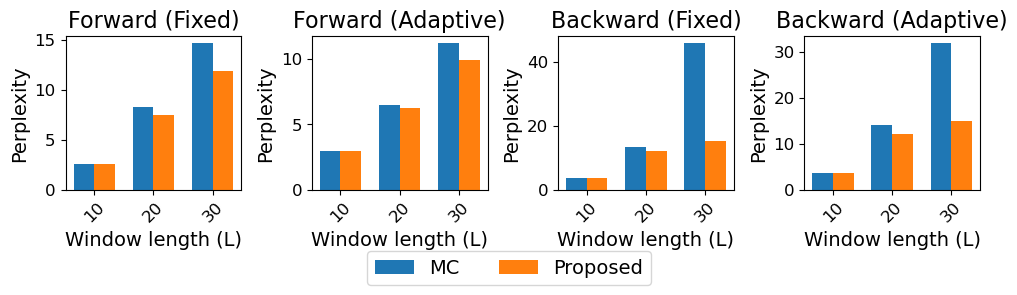

In [89]:
def plot_combined_comparison_bar_graph(perpCF_results: dict, perpCA_results: dict, configurations, subtitles, figsize=(12, 12), 
                                       title_fontsize=14, label_fontsize=12, tick_fontsize=10, legend_fontsize=12) -> None:
    # Creating the figure with 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=figsize)
    axs = axs.ravel()  # Flatten for easier indexing

    for i, config in enumerate(configurations):
        ax = axs[i]
        source1 = perpCF_results[config].reshape(-1, 1)
        source2 = perpCA_results[config].reshape(-1, 1)

        # Ensuring equal length of sources
        if source1.shape[0] != source2.shape[0]:
            raise ValueError("Both sources must have the same number of groups (N).")

        N = source1.shape[0]
        indices = np.arange(N)
        bar_width = 0.35

        # Plotting bars
        ax.bar(indices - bar_width / 2, source1.flatten(), width=bar_width, label='MC')
        ax.bar(indices + bar_width / 2, source2.flatten(), width=bar_width, label='Proposed')

        ax.set_title(f'{subtitles[i]}', fontsize=title_fontsize)
        ax.set_xlabel('Window length (L)', fontsize=label_fontsize)
        ax.set_ylabel('Perplexity', fontsize=label_fontsize)
        ax.set_xticks(indices)
        ax.set_xticklabels(['10', '20', '30'], rotation=45, fontsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust layout and add one single legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=legend_fontsize)

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
    return fig

configurations = [
    ('forward', 'fixed'),
    ('forward', 'adaptive'),
    ('backward', 'fixed'),
    ('backward', 'adaptive')
]
subtitles = [
    'Forward (Fixed)',
    'Forward (Adaptive)',
    'Backward (Fixed)',
    'Backward (Adaptive)'
]
fig = plot_combined_comparison_bar_graph(
    perpCF_results, 
    perpCA_results, 
    configurations, 
    subtitles, 
    figsize=(10, 3), 
    title_fontsize=16, 
    label_fontsize=14, 
    tick_fontsize=12, 
    legend_fontsize=14
)
fig.show()
#fig.savefig("C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/EW2025/figures/preplexity.png", format='png', dpi=300)

In [90]:
print(theresholds)
print(mapping)
N = 1
sourceTraffic = assign_groups(resultsTest['trafficSource_actual'].astype(int), theresholds)
targetTraffic = assign_groups(resultsTest['trafficTarget_actual'].astype(int), theresholds)
logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)
logLikeCA, perpCA = compute_log_likelihood_and_perplexity(transMatrixContextAwareAggregated, sourceTraffic, targetTraffic, N=N)
print(perpCF)
print(perpCA)


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21]
[ 0  0  1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 18 19 19
 19 19 19 19 19 19 19]
[array([25.0416554])]
[array([14.8385813])]
